In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.core import HierarchicalReconciliation

data_dir = os.path.join('..', '..', 'data')
consump_file = 'modern-renewable-energy-consumption.csv'
prod_file = 'modern-renewable-prod.csv'

cols = ['country', 'code', 'year', 'other', 'solar', 'wind', 'hydro']

/Users/ianroberts/opt/miniconda3/lib/python3.8/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# load energy consumption data
consump = pd.read_csv(os.path.join(data_dir, consump_file), names=cols,
                      header=0)
consump['year'] = pd.to_datetime(consump['year'], format='%Y')
consump = consump.set_index(cols[:3])

consump = consump.melt(ignore_index=False)
consump.columns = ['source', 'consumption']

consump = (consump.reset_index(drop=False)
           .set_index(['country', 'code', 'year', 'source']))


# load energy production data
produce = pd.read_csv(os.path.join(data_dir, prod_file), names=cols, header=0)
produce['year'] = pd.to_datetime(produce['year'], format='%Y')
produce = produce.set_index(cols[:3])

produce = produce.melt(ignore_index=False)
produce.columns = ['source', 'production']

produce = (produce.reset_index(drop=False)
           .set_index(['country', 'code', 'year', 'source']))

# merge consumption and production
dat = pd.merge(consump, produce, how='outer', left_index=True, right_index=True)

# select just north american countries
na_countries = ['Canada', 'Mexico', 'United States']
na = dat[dat.index.isin(na_countries, level=0)]
na

consumption  production
country       code year       source                         
Canada        CAN  1965-01-01 hydro     118.08800         NaN
                              other           NaN         NaN
                              solar           NaN  118.088000
                              wind            NaN         NaN
                   1966-01-01 hydro     131.00000         NaN
...                                           ...         ...
United States USA  2021-01-01 wind      382.01694  164.420000
                   2022-01-01 hydro     258.55110   72.619995
                              other      74.16879  434.810000
                              solar     206.17172  255.970000
                              wind      439.20367  204.290000

[696 rows x 2 columns]

In [3]:
# calculate proportion missing values
na.isna().mean()

consumption    0.156609
production     0.156609
dtype: float64

In [4]:
na_wide = na.unstack(level=[0,1,3])
na_wide.info()

consumption                                                       \
country         Canada                                     Mexico             
code               CAN                                        MEX             
source           hydro      other     solar       wind      hydro     other   
year                                                                          
1965-01-01   118.08800        NaN       NaN        NaN   8.863000       NaN   
1966-01-01   131.00000        NaN       NaN        NaN  10.118000       NaN   
1967-01-01   133.92400        NaN       NaN        NaN  11.017000       NaN   
1968-01-01   136.20000        NaN       NaN        NaN  12.642000       NaN   
1969-01-01   150.63800        NaN       NaN        NaN  13.406000       NaN   
1970-01-01   158.13700        NaN       NaN        NaN  15.005000       NaN   
1971-01-01   162.46100        NaN       NaN        NaN  14.572000  0.000000   
1972-01-01   181.63900        NaN       NaN        NaN  15.531000  0.000000   
1973-01-01   194.65400        NaN       NaN        NaN  16.371000  0.161000   
1974-01-01   210.66700        NaN       NaN        NaN  16.708000  0.463000   
1975-01-01   202.47000   0.000000       NaN        NaN  15.182000  0.518000   
1976-01-01   212.68900   0.707000       NaN        NaN  17.255000  0.579000   
1977-01-01   220.14700   1.069000       NaN        NaN  19.193000  0.592000   
1978-01-01   235.25400   1.132000       NaN        NaN  16.217000  0.598000   
1979-01-01   244.12100   1.345000       NaN        NaN  18.008000  1.019000   
1980-01-01   251.14800   1.300000       NaN        NaN  16.910000  0.915000   
1981-01-01   266.01500   1.898000       NaN        NaN  24.618000  0.964000   
1982-01-01   257.79500   2.139000       NaN        NaN  22.924000  1.296000   
1983-01-01   265.95200   2.085000       NaN        NaN  20.733000  1.353000   
1984-01-01   286.12300   2.337000       NaN        NaN  23.603000  1.424000   
1985-01-01   303.64500   1.677000       NaN   0.001000  28.427292  1.641000   
1986-01-01   310.63500   1.865000       NaN   0.001000  21.297500  3.394000   
1987-01-01   316.20600   2.312000       NaN   0.001000  19.285194  4.418000   
1988-01-01   307.43500   2.485000       NaN   0.001000  21.836111  4.633000   
1989-01-01   290.44974   3.477000       NaN   0.001000  25.354195  4.675000   
1990-01-01   295.68332   3.954000  0.000000   0.001919  24.480944  5.124000   
1991-01-01   307.27600   3.984000  0.000000   0.001919  22.625263  5.832512   
1992-01-01   315.17465   4.465000  0.002053   0.059000  26.813694  6.365523   
1993-01-01   322.21390   4.817000  0.002053   0.059000  26.654930  6.499761   
1994-01-01   327.85560   5.733000  0.002053   0.059000  20.271320  6.218525   
1995-01-01   334.05972   7.137866  0.003842   0.059000  27.598667  6.414443   
1996-01-01   354.59207   7.528515  0.005895   0.062000  31.336277  6.184555   
1997-01-01   348.67963   8.168220  0.006947   0.062000  26.362097  5.883246   
1998-01-01   330.86993   8.987254  0.010105   0.062000  24.592945  6.138586   
1999-01-01   345.00080   8.943149  0.013263   0.162000  32.712320  6.060001   
2000-01-01   356.76007   8.917043  0.016421   0.264000  33.074880  6.358645   
2001-01-01   331.52103   9.672150  0.019579   0.329000  28.435330  6.247497   
2002-01-01   349.27463  10.046104  0.022737   0.405000  24.861590  6.071060   
2003-01-01   336.13937   9.417295  0.022789   0.690000  19.852205  6.949713   
2004-01-01   338.39835   9.804526  0.014263   0.945000  25.176394  7.261834   
2005-01-01   361.95575   9.155414  0.017000   1.567455  27.709446  8.137519   
2006-01-01   352.88730   8.938046  0.021000   2.473066  30.446474  7.487387   
2007-01-01   367.62146   8.991077  0.026000   3.007279  27.339674  8.249913   
2008-01-01   377.48773   7.978966  0.035000   3.788514  39.223907  7.896158   
2009-01-01   368.68740   8.942057  0.109000   6.641652  26.722006  7.547069   
2010-01-01   351.38480  10.297558  0.255556   8.724192  37.15

In [5]:
na_wide.bfill(inplace=True)
na = na_wide.stack(level=[1,2,3])

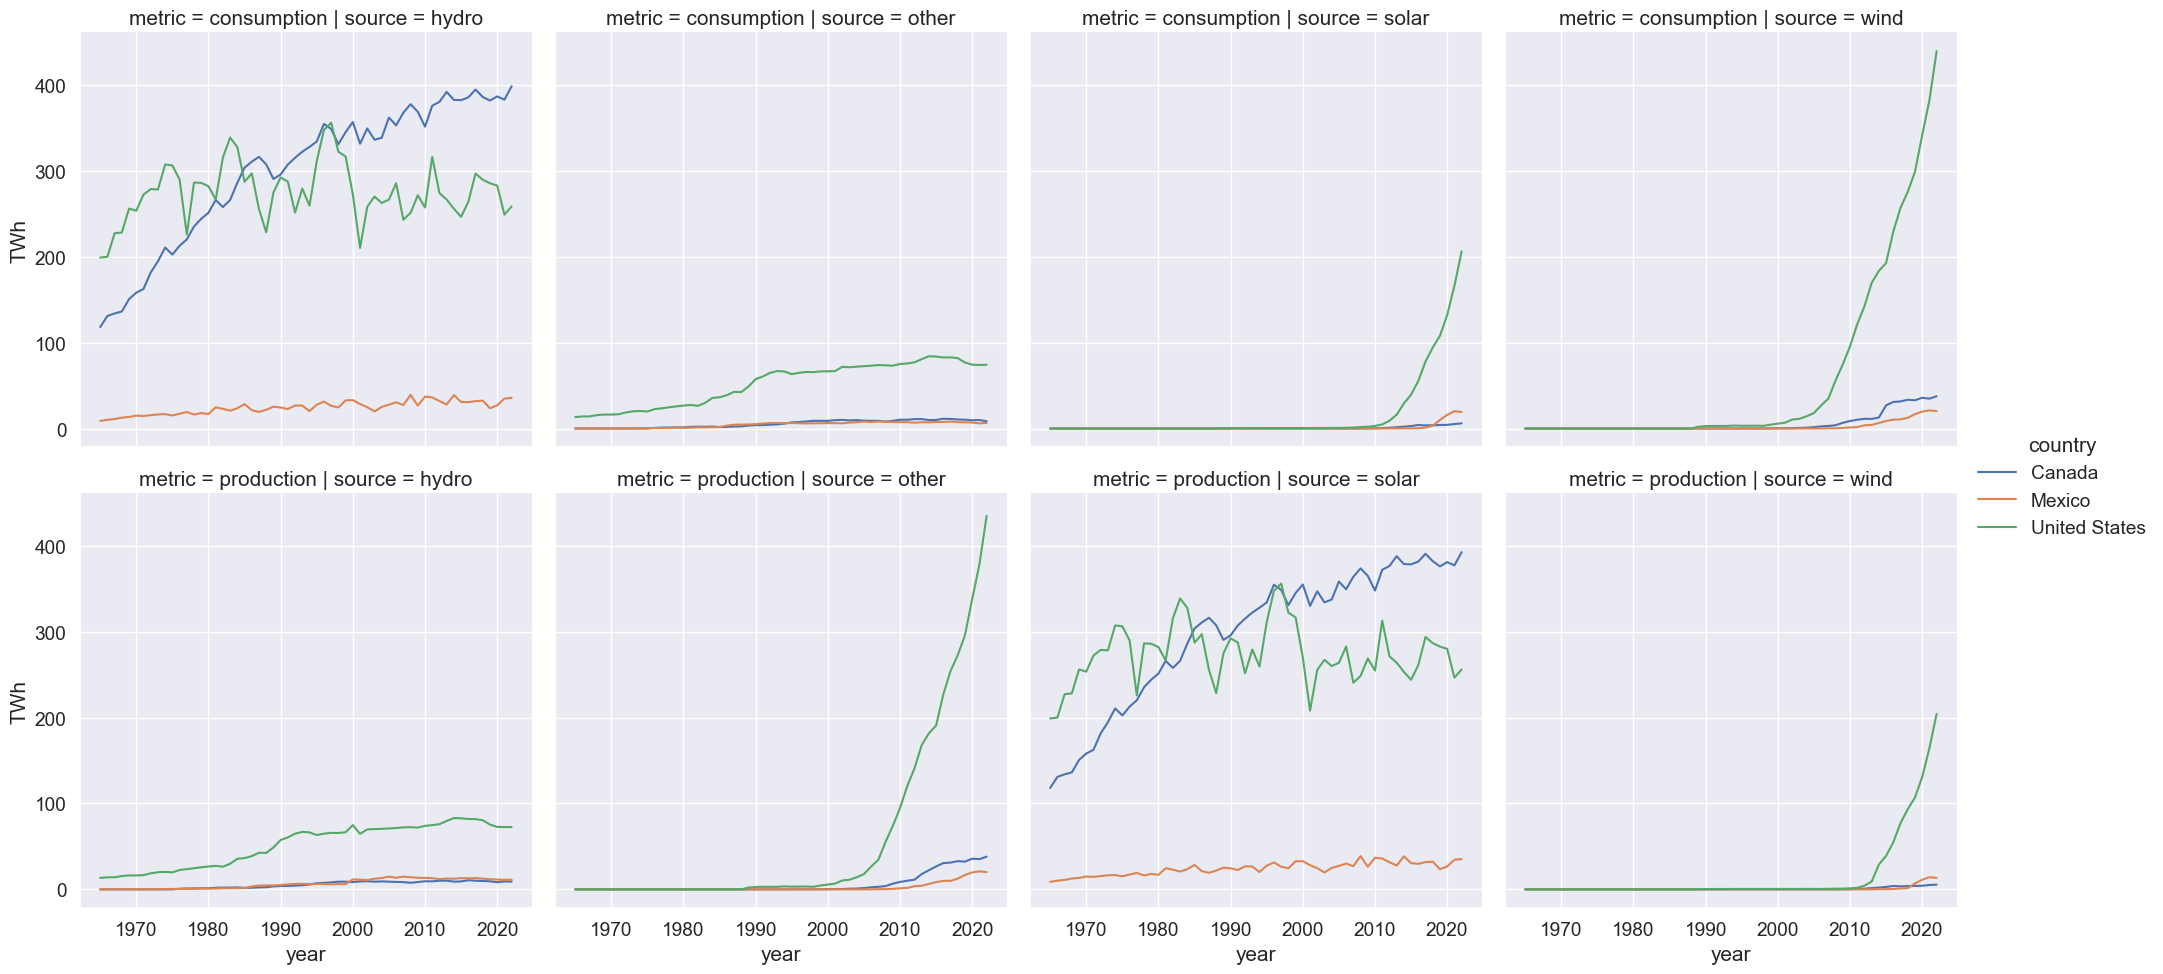

In [6]:
# plot raw energy consumption and production trends
na_long = na.melt(ignore_index=False)
na_long.columns = ['metric', 'TWh']
sns.set(font_scale=1.25)
sns.relplot(data=na_long, x='year', y='TWh', col='source', row='metric',
            hue='country', kind='line')

In [14]:
# fit hierarchical forecast model for renewable energy consumption

na_c = na.reset_index()
na_c.columns = ['ds', 'country', 'code', 'source', 'y', 'production']
na_c = na_c[['country', 'source', 'ds', 'y']]
na_c['metric'] = 'consumption'
na_c = na_c.dropna()

# split into train and test datasets
na_train_c = na_c.loc[na_c['ds'] <= '2015']
na_test_c = na_c.loc[na_c['ds'] > '2015']
h = na_test_c['ds'].nunique()

# define hierarchical structure of model
spec = [['metric'],
        ['metric', 'country'],
        ['metric', 'country', 'source']]

na_train_agg_c, S_train_c, tags_c = aggregate(na_train_c, spec)
na_test_agg_c, _, _ = aggregate(na_test_c, spec)

# fit ARIMA with auto selection of order parameters
na_model_c = StatsForecast(models=[AutoARIMA(seasonal=False, allowdrift=True)],
                           freq='Y', n_jobs=-1)
na_model_c.fit(na_train_agg_c)

# extract forecast predictions (with 95% CI) and fitted values from models
p_c = na_model_c.forecast(h=h, fitted=True, level=[95])
p_fitted_c = na_model_c.forecast_fitted_values()

# correct date so that predictions can be merged with data (not sure why but it 
# gets shifted in the process for some reason)
p_c['ds'] = p_c['ds'] + pd.Timedelta(days=1)

# reconcile forecasts with both a bottom-up and MinT OLS approach
reconcilers = [BottomUp(), 
               MinTrace(method='ols', nonnegative=True)]

rec_model_c = HierarchicalReconciliation(reconcilers=reconcilers)

p_rec_c = rec_model_c.reconcile(Y_hat_df=p_c,
                                Y_df=p_fitted_c, S=S_train_c, tags=tags_c,
                                level=[95])

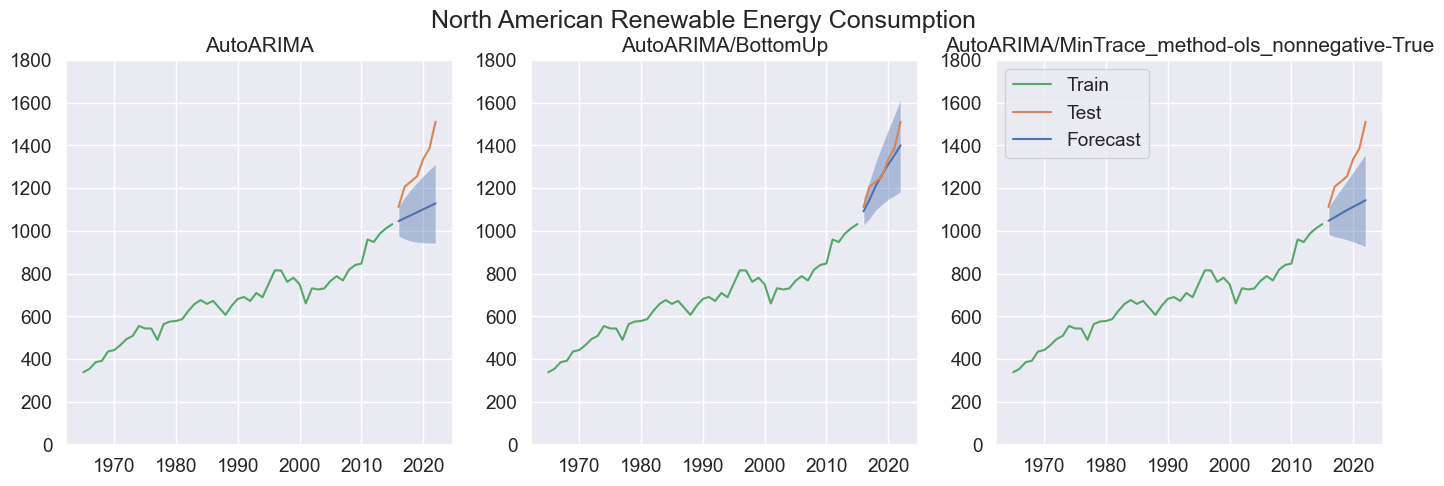

In [15]:
# plot hierarchical north american consumption forecasts

forecast_cols = [['AutoARIMA', 'AutoARIMA-lo-95', 'AutoARIMA-hi-95'],
                 ['AutoARIMA/BottomUp', 'AutoARIMA/BottomUp-lo-95',
                  'AutoARIMA/BottomUp-hi-95'],
                 ['AutoARIMA/MinTrace_method-ols_nonnegative-True',
                  'AutoARIMA/MinTrace_method-ols_nonnegative-True-lo-95',
                  'AutoARIMA/MinTrace_method-ols_nonnegative-True-hi-95']]

fig, axes = plt.subplots(ncols=3, figsize=(17, 5))


for i, ax in enumerate(axes):
    ax.fill_between(p_rec_c.loc[p_rec_c.index == 'consumption', 'ds'],
                    p_rec_c.loc[p_rec_c.index == 'consumption', forecast_cols[i][1]],
                    p_rec_c.loc[p_rec_c.index == 'consumption', forecast_cols[i][2]],
                    alpha=0.4)
    
    l1, = ax.plot(p_rec_c.loc[p_rec_c.index == 'consumption', 'ds'],
            p_rec_c.loc[p_rec_c.index == 'consumption', forecast_cols[i][0]])

    l2, = ax.plot(na_test_agg_c.loc[na_test_agg_c.index == 'consumption', 'ds'],
            na_test_agg_c.loc[na_test_agg_c.index == 'consumption', 'y'])

    l3, = ax.plot(na_train_agg_c.loc[na_train_agg_c.index == 'consumption', 'ds'],
            na_train_agg_c.loc[na_train_agg_c.index == 'consumption', 'y'])

    ax.set_ylim([0, 1800])
    ax.title.set_text(forecast_cols[i][0])

plt.legend([l3, l2, l1], ['Train', 'Test', 'Forecast'])
fig.suptitle('North American Renewable Energy Consumption')
plt.show()

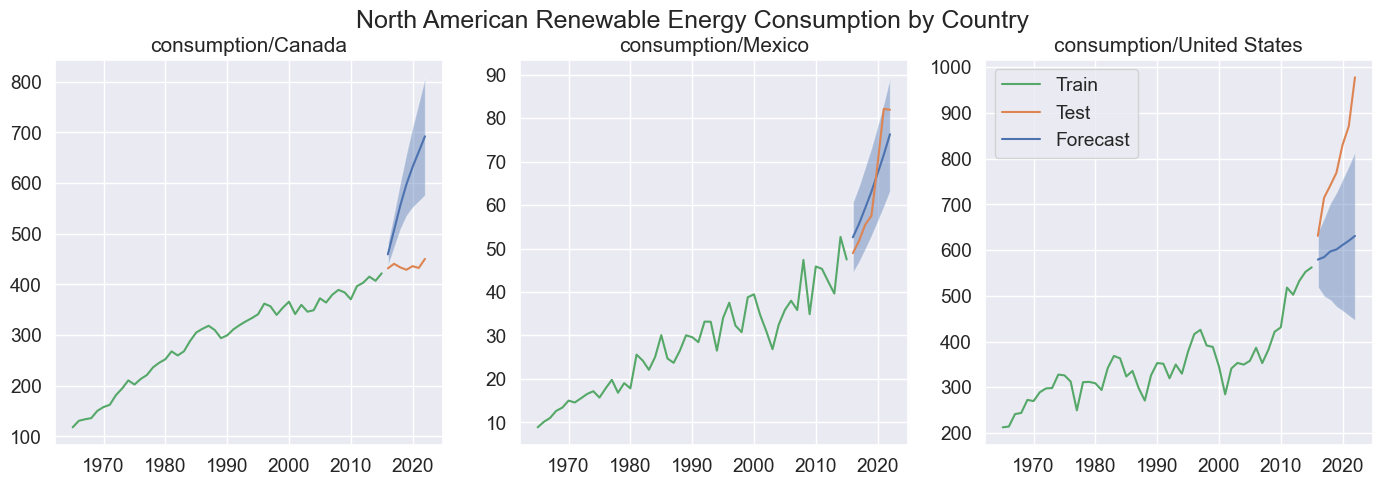

In [16]:
# plot hierarchical consumption forecasts by country

plot_levels = ['consumption/Canada', 'consumption/Mexico',
               'consumption/United States']

fig, axes = plt.subplots(ncols=3, figsize=(17, 5))

for i, ax in enumerate(axes):
    ax.fill_between(p_rec_c.loc[p_rec_c.index == plot_levels[i], 'ds'],
                    p_rec_c.loc[p_rec_c.index == plot_levels[i], 'AutoARIMA/BottomUp-lo-95'],
                    p_rec_c.loc[p_rec_c.index == plot_levels[i], 'AutoARIMA/BottomUp-hi-95'],
                    alpha=0.4)
    
    l1, = ax.plot(p_rec_c.loc[p_rec_c.index == plot_levels[i], 'ds'],
            p_rec_c.loc[p_rec_c.index == plot_levels[i], 'AutoARIMA/BottomUp'])

    l2, = ax.plot(na_test_agg_c.loc[na_test_agg_c.index == plot_levels[i], 'ds'],
            na_test_agg_c.loc[na_test_agg_c.index == plot_levels[i], 'y'])

    l3, = ax.plot(na_train_agg_c.loc[na_train_agg_c.index == plot_levels[i], 'ds'],
            na_train_agg_c.loc[na_train_agg_c.index == plot_levels[i], 'y'])

#     ax.set_ylim([0, 1100])
    ax.title.set_text(plot_levels[i])

plt.legend([l3, l2, l1], ['Train', 'Test', 'Forecast'])
fig.suptitle('North American Renewable Energy Consumption by Country')
plt.show()

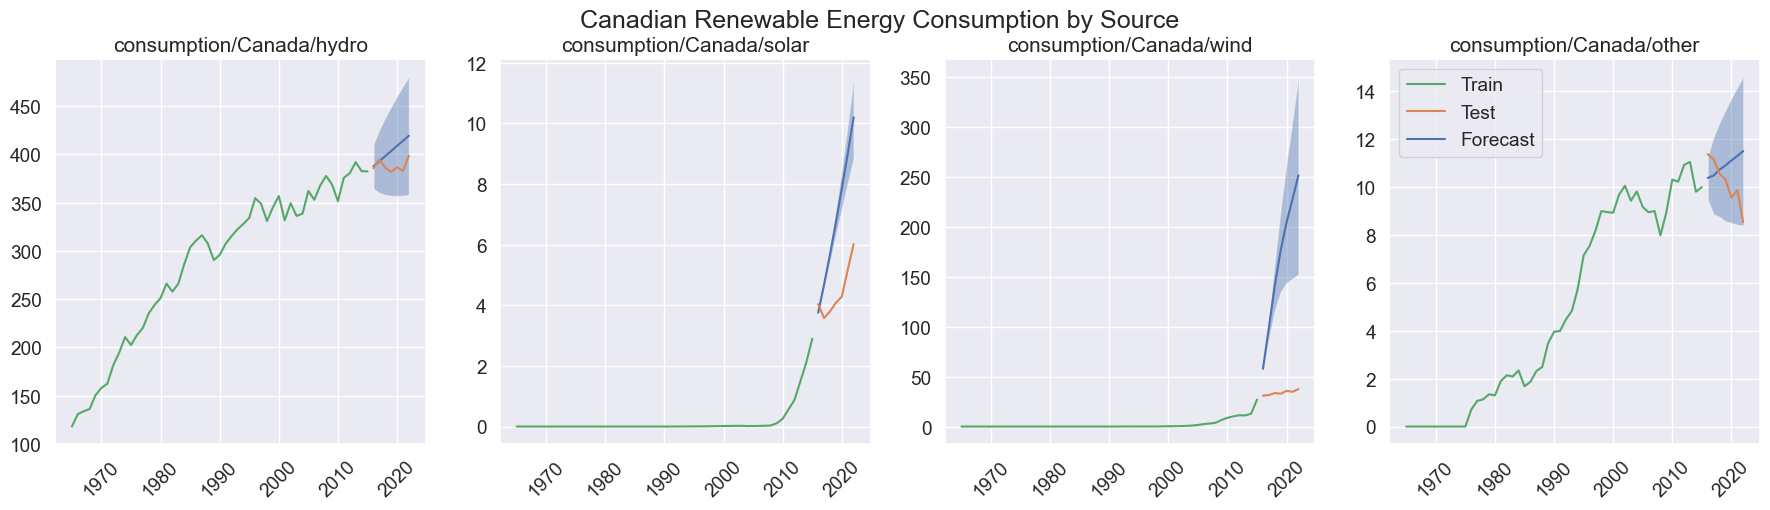

In [17]:
# plot hierarchical consumption forecasts for Canada by source

plot_levels = ['consumption/Canada/hydro', 'consumption/Canada/solar',
               'consumption/Canada/wind', 'consumption/Canada/other']

fig, axes = plt.subplots(ncols=4, figsize=(22, 5))

for i, ax in enumerate(axes):
    ax.fill_between(p_rec_c.loc[p_rec_c.index == plot_levels[i], 'ds'],
                    p_rec_c.loc[p_rec_c.index == plot_levels[i], 'AutoARIMA/BottomUp-lo-95'],
                    p_rec_c.loc[p_rec_c.index == plot_levels[i], 'AutoARIMA/BottomUp-hi-95'],
                    alpha=0.4)
    
    l1, = ax.plot(p_rec_c.loc[p_rec_c.index == plot_levels[i], 'ds'],
            p_rec_c.loc[p_rec_c.index == plot_levels[i], 'AutoARIMA/BottomUp'])

    l2, = ax.plot(na_test_agg_c.loc[na_test_agg_c.index == plot_levels[i], 'ds'],
            na_test_agg_c.loc[na_test_agg_c.index == plot_levels[i], 'y'])

    l3, = ax.plot(na_train_agg_c.loc[na_train_agg_c.index == plot_levels[i], 'ds'],
            na_train_agg_c.loc[na_train_agg_c.index == plot_levels[i], 'y'])

#     ax.set_ylim([0, 600])
    ax.title.set_text(plot_levels[i])
    ax.tick_params('x', labelrotation=45)

plt.legend([l3, l2, l1], ['Train', 'Test', 'Forecast'])
fig.suptitle('Canadian Renewable Energy Consumption by Source')
plt.show()

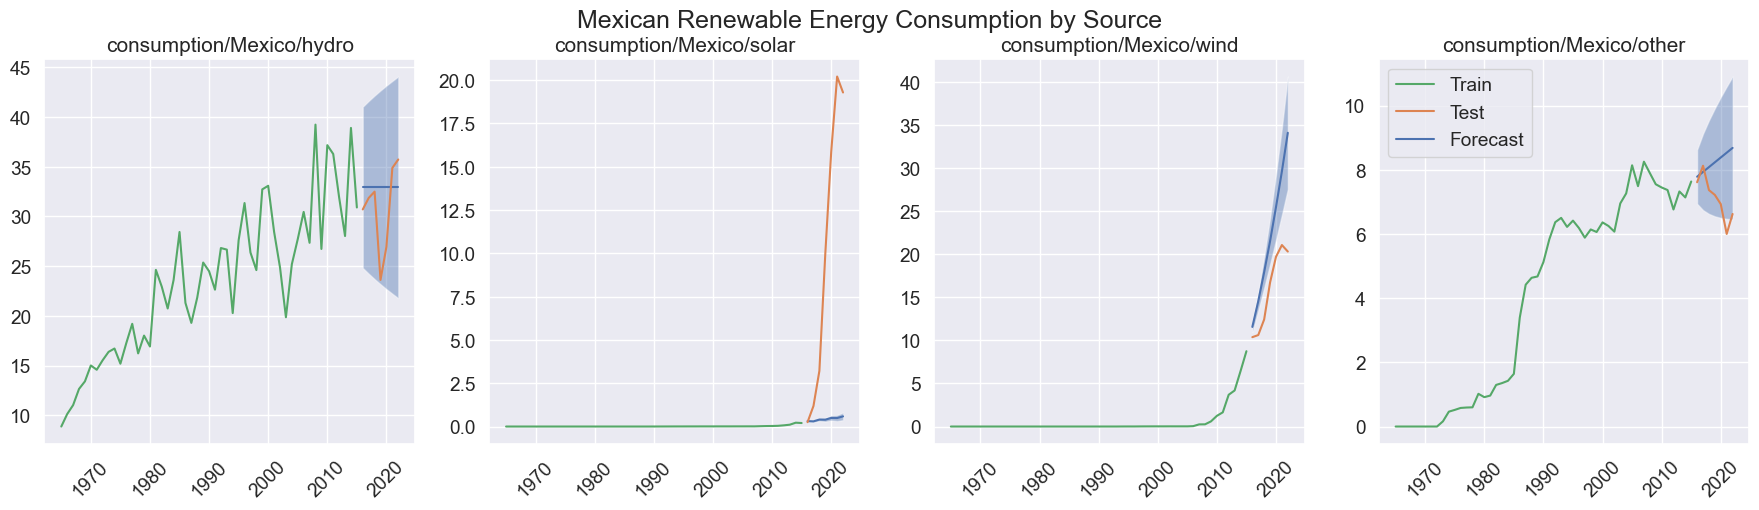

In [18]:
# plot hierarchical consumption forecasts for Mexico by source

plot_levels = ['consumption/Mexico/hydro', 'consumption/Mexico/solar',
               'consumption/Mexico/wind', 'consumption/Mexico/other']

fig, axes = plt.subplots(ncols=4, figsize=(22, 5))

for i, ax in enumerate(axes):
    ax.fill_between(p_rec_c.loc[p_rec_c.index == plot_levels[i], 'ds'],
                    p_rec_c.loc[p_rec_c.index == plot_levels[i], 'AutoARIMA/BottomUp-lo-95'],
                    p_rec_c.loc[p_rec_c.index == plot_levels[i], 'AutoARIMA/BottomUp-hi-95'],
                    alpha=0.4)
    
    l1, = ax.plot(p_rec_c.loc[p_rec_c.index == plot_levels[i], 'ds'],
            p_rec_c.loc[p_rec_c.index == plot_levels[i], 'AutoARIMA/BottomUp'])

    l2, = ax.plot(na_test_agg_c.loc[na_test_agg_c.index == plot_levels[i], 'ds'],
            na_test_agg_c.loc[na_test_agg_c.index == plot_levels[i], 'y'])

    l3, = ax.plot(na_train_agg_c.loc[na_train_agg_c.index == plot_levels[i], 'ds'],
            na_train_agg_c.loc[na_train_agg_c.index == plot_levels[i], 'y'])

#     ax.set_ylim([0, 600])
    ax.title.set_text(plot_levels[i])
    ax.tick_params('x', labelrotation=45)

plt.legend([l3, l2, l1], ['Train', 'Test', 'Forecast'])
fig.suptitle('Mexican Renewable Energy Consumption by Source')
plt.show()

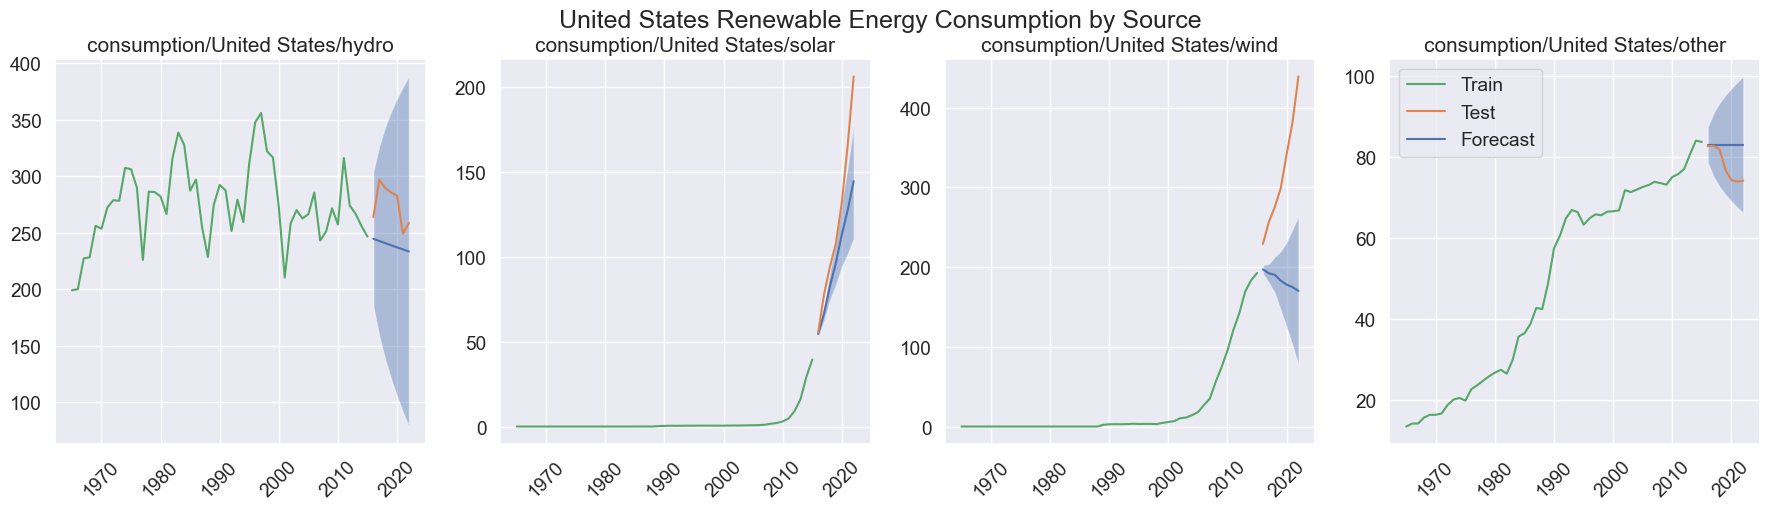

In [19]:
# plot hierarchical consumption forecasts for United States by source

plot_levels = ['consumption/United States/hydro', 'consumption/United States/solar',
               'consumption/United States/wind', 'consumption/United States/other']

fig, axes = plt.subplots(ncols=4, figsize=(22, 5))

for i, ax in enumerate(axes):
    ax.fill_between(p_rec_c.loc[p_rec_c.index == plot_levels[i], 'ds'],
                    p_rec_c.loc[p_rec_c.index == plot_levels[i], 'AutoARIMA/BottomUp-lo-95'],
                    p_rec_c.loc[p_rec_c.index == plot_levels[i], 'AutoARIMA/BottomUp-hi-95'],
                    alpha=0.4)
    
    l1, = ax.plot(p_rec_c.loc[p_rec_c.index == plot_levels[i], 'ds'],
            p_rec_c.loc[p_rec_c.index == plot_levels[i], 'AutoARIMA/BottomUp'])

    l2, = ax.plot(na_test_agg_c.loc[na_test_agg_c.index == plot_levels[i], 'ds'],
            na_test_agg_c.loc[na_test_agg_c.index == plot_levels[i], 'y'])

    l3, = ax.plot(na_train_agg_c.loc[na_train_agg_c.index == plot_levels[i], 'ds'],
            na_train_agg_c.loc[na_train_agg_c.index == plot_levels[i], 'y'])

#     ax.set_ylim([0, 600])
    ax.title.set_text(plot_levels[i])
    ax.tick_params('x', labelrotation=45)

plt.legend([l3, l2, l1], ['Train', 'Test', 'Forecast'])
fig.suptitle('United States Renewable Energy Consumption by Source')
plt.show()

In [20]:
# fit hierarchical forecast model for renewable energy production

na_p = na.reset_index()
na_p.columns = ['ds', 'country', 'code', 'source', 'consumption', 'y']
na_p = na_p[['country', 'source', 'ds', 'y']]
na_p['metric'] = 'production'
na_p = na_p.dropna()

# split into train and test datasets
na_train_p = na_p.loc[na_p['ds'] <= '2015']
na_test_p = na_p.loc[na_p['ds'] > '2015']
h = na_test_p['ds'].nunique()

# define hierarchical structure of model
spec = [['metric'],
        ['metric', 'country'],
        ['metric', 'country', 'source']]

na_train_agg_p, S_train_p, tags_p = aggregate(na_train_p, spec)
na_test_agg_p, _, _ = aggregate(na_test_p, spec)

# fit ARIMA with auto selection of order parameters
na_model_p = StatsForecast(models=[AutoARIMA(seasonal=False, allowdrift=True)],
                           freq='Y', n_jobs=-1)
na_model_p.fit(na_train_agg_p)

# extract forecast predictions (with 95% CI) and fitted values from models
p_p = na_model_p.forecast(h=h, fitted=True, level=[95])
p_fitted_p = na_model_p.forecast_fitted_values()

# correct date so that predictions can be merged with data (not sure why but it 
# gets shifted in the process for some reason)
p_p['ds'] = p_p['ds'] + pd.Timedelta(days=1)

# reconcile forecasts with both a bottom-up and MinT OLS approach
reconcilers = [BottomUp(), 
               MinTrace(method='ols', nonnegative=True)]

rec_model_p = HierarchicalReconciliation(reconcilers=reconcilers)

p_rec_p = rec_model_p.reconcile(Y_hat_df=p_p,
                                Y_df=p_fitted_p, S=S_train_p, tags=tags_p,
                                level=[95])

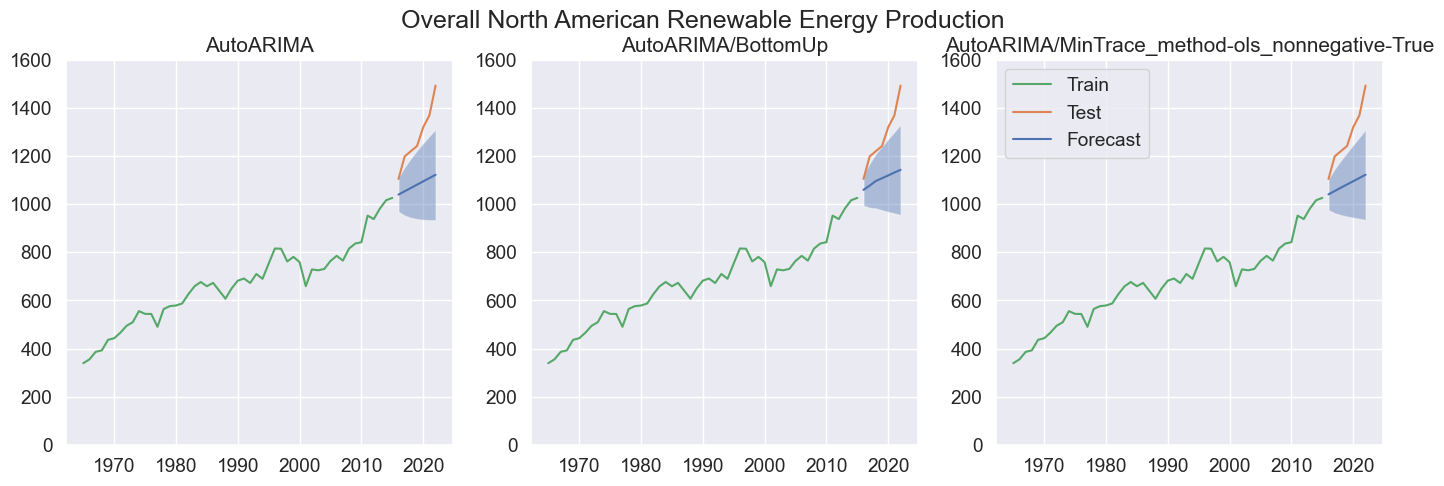

In [21]:
# plot north american production forecasts
na_train_agg_p['dataset'] = 'Train'
na_test_agg_p['dataset'] = 'Test'
p_rec_p['dataset'] = 'Forecast'

forecast_cols = [['AutoARIMA', 'AutoARIMA-lo-95', 'AutoARIMA-hi-95'],
                 ['AutoARIMA/BottomUp', 'AutoARIMA/BottomUp-lo-95',
                  'AutoARIMA/BottomUp-hi-95'],
                 ['AutoARIMA/MinTrace_method-ols_nonnegative-True',
                  'AutoARIMA/MinTrace_method-ols_nonnegative-True-lo-95',
                  'AutoARIMA/MinTrace_method-ols_nonnegative-True-hi-95']]

fig, axes = plt.subplots(ncols=3, figsize=(17, 5))


for i, ax in enumerate(axes):
    ax.fill_between(p_rec_p.loc[p_rec_p.index == 'production', 'ds'],
                    p_rec_p.loc[p_rec_p.index == 'production', forecast_cols[i][1]],
                    p_rec_p.loc[p_rec_p.index == 'production', forecast_cols[i][2]],
                    alpha=0.4)
    
    l1, = ax.plot(p_rec_p.loc[p_rec_p.index == 'production', 'ds'],
                  p_rec_p.loc[p_rec_p.index == 'production', forecast_cols[i][0]])

    l2, = ax.plot(na_test_agg_p.loc[na_test_agg_p.index == 'production', 'ds'],
                  na_test_agg_p.loc[na_test_agg_p.index == 'production', 'y'])

    l3, = ax.plot(na_train_agg_p.loc[na_train_agg_p.index == 'production', 'ds'],
                  na_train_agg_p.loc[na_train_agg_p.index == 'production', 'y'])

    ax.set_ylim([0, 1600])
    ax.title.set_text(forecast_cols[i][0])

plt.legend([l3, l2, l1], ['Train', 'Test', 'Forecast'])
fig.suptitle('Overall North American Renewable Energy Production')
plt.show()